# Exercise: What is the classifier picking up on with the top-2 results? 

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE

import sklearn
from sklearn.inspection import permutation_importance


In [78]:
# version = 'old'
version = 'clare_basis'
# version = 'clare_all'


In [79]:
if version == 'old':
    fn = 'lfc_mb_filt_OLD.csv' ## data set without Claire's screens
elif version == 'clare_all':
    fn = 'lfc_mb_filt.csv' ## data set with all of Claire's pairwise combinations
elif version == 'clare_basis':
    fn = 'lfc_mb_filt_BASIS.csv' ## data set only Claire's mutant vs. wildtype screens

path = '../data/standardized_data/cleaned_ML/'
df_lfc = pd.read_csv(os.path.join(path, fn))
df_lfc.shape

(2937, 130)

In [80]:
# X and y
cols_data = df_lfc.columns[1:-1]
X = df_lfc[cols_data].to_numpy()
print(X.shape)

list_categories = df_lfc.Functional_Category.unique().tolist()
list_categories


(2937, 128)


['information pathways',
 'cell wall and cell processes',
 'intermediary metabolism and respiration',
 'regulatory proteins',
 'virulence, detoxification, adaptation',
 'insertion seqs and phages',
 'lipid metabolism',
 'PE/PPE']

In [81]:
model = 'logreg'
# model = 'xgbc'

In [121]:
n_splits = 5
n_classes = 2
shuffle = False

category = 'PE/PPE' # 'insertion seqs and phages' # 'insertion seqs and phages' 
y = np.zeros(df_lfc.shape[0])
ind_ones = [i for i in range(df_lfc.shape[0]) if df_lfc.iloc[i].Functional_Category == category]
y[ind_ones] = 1

if shuffle: # shuffle y vector.
    random.shuffle(y)

if model == 'logreg':
    reg_param_temp = 1e-1
    clf = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=reg_param_temp)
elif model == 'xgbc':
    clf = XGBClassifier(gamma = reg_param_temp, reg_alpha=1, reg_lambda=1)

skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train, y_train = SMOTE().fit_resample(X_train, y_train) # understand this step. 
    # fit model
    clf.fit(X_train, y_train)

Version 1: inspecting coefficients: 

(-0.8, 0.8)

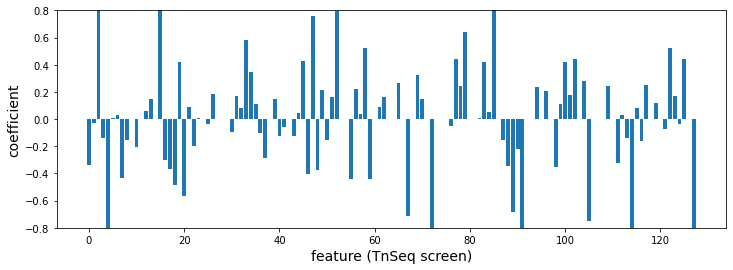

In [122]:
importance = clf.coef_[0]
plt.figure(figsize=(12, 4))
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('feature (TnSeq screen)', fontsize=14)
yl = plt.ylabel('coefficient', fontsize=14)
plt.ylim(-0.8, 0.8)

(-0.5, 0.5)

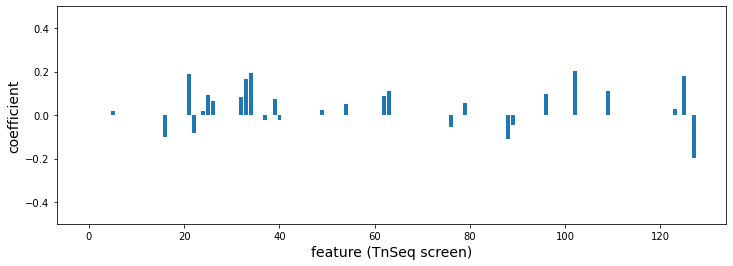

In [97]:
importance = clf.coef_[0]
plt.figure(figsize=(12, 4))
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('feature (TnSeq screen)', fontsize=14)
yl = plt.ylabel('coefficient', fontsize=14)
plt.ylim(-1, 1)

In [104]:
ind_top10 = np.argsort(np.abs(importance))[-10:]
cols_data[ind_top10[::-1]]

Index(['in_vitro_vs_C57BL.6J', 'C57BL.6J_vs_mbio_H37Rv',
       'carey_632_vs_carey_rv', 'carey_663_vs_carey_rv', 'IFNG_vs_C57BL.6J',
       'mishra_C3H_vs_mishra_B6', 'PWK.PhJ_vs_C57BL.6J',
       'dejesus_H37Rv_day32_vs_dejesus_H37Rv_day0', '129s1.SvImJ_vs_C57BL.6J',
       'dejesus_Rv1565c_day0_vs_dejesus_H37Rv_day0'],
      dtype='object')

Version 2: permutation importance: 

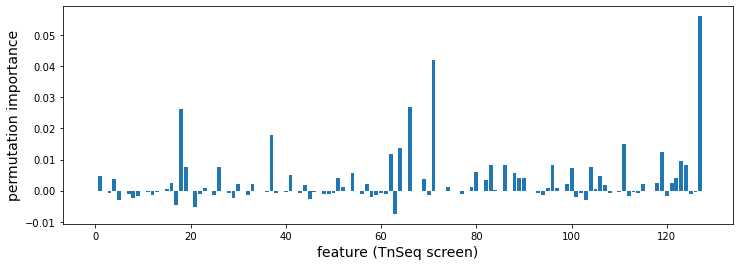

In [85]:
results = permutation_importance(clf, X, y, scoring='accuracy') # scoring = 'neg_log_loss'
importance_perm = results.importances_mean
plt.figure(figsize=(12, 4))
plt.bar([x for x in range(len(importance_perm))], importance_perm)
plt.xlabel('feature (TnSeq screen)', fontsize=14)
yl = plt.ylabel('permutation importance', fontsize=14)

In [86]:
ind_top10 = np.argsort(np.abs(importance_perm))[-10:]
cols_data[ind_top10[::-1]]

Index(['in_vitro_vs_C57BL.6J', 'CC002.Unc_vs_C57BL.6J',
       'C57BL.6J_vs_129s1.SvImJ', 'carey_662_vs_carey_rv',
       'kieser_dPonA1_vs_mbio_H37Rv', 'CC047.Unc_vs_C57BL.6J',
       '129s1.SvImJ_vs_C57BL.6J', 'IFNG_vs_C57BL.6J',
       'zhang_wt_mouse_d10_vs_zhang_input_library', 'PWK.PhJ_vs_C57BL.6J'],
      dtype='object')